In [11]:
# %pip install pandas numpy
# %pip install scikit-learn
# %pip install RDKit
# %pip install matplotlib networkx
# %pip install tqdm 
# %pip install rdkit
# %pip install xgboost
# %pip install sklearn

In [12]:
nbt = 2048
threshold = 0.3

# 思路记录
## 

# 1.数据预处理
### 缺失值
- `用1填充`：宁愿误判为有毒性也不判为无毒 ❌效果不理想

- `略过缺失值`?
逐标签过滤缺失值 ✅	模型严谨、标签缺失较多时



In [13]:
import pandas as pd
import numpy as np
tox_data = pd.read_csv('../data/tox21.csv')
tox_data.head(2)

,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles
0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O


In [14]:
# Step 1: 识别标签列（12个毒性相关的列）
label_cols = [
    'NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER',
    'NR-ER-LBD', 'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5',
    'SR-HSE', 'SR-MMP', 'SR-p53'
]

# Step 2: 统计标签完全缺失和完全非缺失的样本数量
total_samples = tox_data.shape[0]
all_nan_labels = tox_data[label_cols].isna().all(axis=1).sum()
no_nan_labels = tox_data[label_cols].notna().all(axis=1).sum()
partial_nan_labels = total_samples - all_nan_labels - no_nan_labels

{
    "总样本数": total_samples,
    "标签全缺失样本数": int(all_nan_labels),
    "标签无缺失样本数": int(no_nan_labels),
    "标签部分缺失样本数": int(partial_nan_labels)
}
# 统计每个标签缺失值的数量
missing_counts_per_label = tox_data[label_cols].isna().sum().sort_values(ascending=False)

missing_counts_per_label

# ## 缺失样本设置为1（不具备该特征）
# # 将所有标签列中的缺失值填充为 0，表示“无该毒性特征”
# tox_data[label_cols] = tox_data[label_cols].fillna(1)

# # 检查是否填充成功（应返回 0）
# remaining_missing = tox_data[label_cols].isna().sum().sum()
# int(remaining_missing)


SR-MMP           2092
SR-ARE           2078
NR-Aromatase     2072
NR-ER            1697
NR-PPAR-gamma    1430
SR-HSE           1419
NR-AhR           1322
NR-AR-LBD        1111
SR-p53           1104
NR-ER-LBD         901
SR-ATAD5          781
NR-AR             574
dtype: int64

## 📍 Step 2：特征工程（分子指纹提取）
### 使用 RDKit 提取每个 SMILES 的 ECFP4指纹：

- radius=2，生成 ECFP4
- 设置固定向量长度，如 nBits=1024
- 每个分子将转换为一个 0/1的稀疏向量

### 最终特征矩阵形状：(num_samples, 1024)

In [15]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from tqdm import tqdm

# 定义 SMILES → ECFP4 指纹向量函数
def smiles_to_ecfp4(smiles, radius=2, nBits= nbt):
    mol = Chem.MolFromSmiles(smiles)  # 用RDKit将SMILES转成分子对象（Mol）
    if mol is None:
        return np.zeros(nBits, dtype=int)  # 无效的SMILES返回全0向量

    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits)  
    # 生成ECFP4分子指纹，radius=2表示ECFP4，nBits表示指纹长度（如1024位）

    arr = np.zeros((nBits,), dtype=int)  # 先创建一个全0的一维数组
    DataStructs.ConvertToNumpyArray(fp, arr)  # 把指纹位向量（BitVect）复制到numpy数组中
    return arr  # 返回一个 numpy 的 0/1 向量，长度为 nBits

# 应用处理
tqdm.pandas()
X_fp = np.vstack(tox_data['smiles'].progress_apply(smiles_to_ecfp4))

# 标签矩阵
y = tox_data[label_cols].values

# 输出结果形状
print("特征矩阵 X_fp.shape =", X_fp.shape)
print("标签矩阵 y.shape =", y.shape)


  0%|          | 0/8006 [00:00<?, ?it/s][12:10:45] DEPRECATION WARNING: please use MorganGenerator
[12:10:45] DEPRECATION WARNING: please use MorganGenerator
[12:10:45] DEPRECATION WARNING: please use MorganGenerator
[12:10:45] DEPRECATION WARNING: please use MorganGenerator
[12:10:45] DEPRECATION WARNING: please use MorganGenerator
[12:10:45] DEPRECATION WARNING: please use MorganGenerator
[12:10:45] DEPRECATION WARNING: please use MorganGenerator
[12:10:45] DEPRECATION WARNING: please use MorganGenerator
[12:10:45] DEPRECATION WARNING: please use MorganGenerator
[12:10:45] DEPRECATION WARNING: please use MorganGenerator
[12:10:45] DEPRECATION WARNING: please use MorganGenerator
[12:10:45] DEPRECATION WARNING: please use MorganGenerator
[12:10:45] DEPRECATION WARNING: please use MorganGenerator
[12:10:45] DEPRECATION WARNING: please use MorganGenerator
[12:10:45] DEPRECATION WARNING: please use MorganGenerator
[12:10:45] DEPRECATION WARNING: please use MorganGenerator
[12:10:45] DEPRE

特征矩阵 X_fp.shape = (8006, 2048)
标签矩阵 y.shape = (8006, 12)


## 📍 Step 3：模型选择与训练
### 模型类型：多标签分类（Multi-label classification）
- 每个样本可能属于多个类别（例如第1个分子同时毒性激活AR和ER）

### 推荐方式：Binary Relevance策略 + XGBoost（Gradient Boosting）
- 将问题分成12个独立的二分类任务
- 为每个标签训练一个独立的 XGBoost 模型

### 尽量降低FN？
-  调整threshold
y_pred = (y_proba > 0.3).astype(int)
- 使用 Recall 指标
- 阈值自动调优

### 调整threshold =.3 FP太高了
<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Positive Rate</th>
      <th>TP Rate</th>
      <th>FP Rate</th>
      <th>Recall@0.3</th>
      <th>Accuracy</th>
      <th>AUC</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>NR-AR-LBD</th>
      <td>0.0348</td>
      <td>0.7000</td>
      <td>0.3000</td>
      <td>0.5833</td>
      <td>0.9768</td>
      <td>0.8415</td>
    </tr>
    <tr>
      <th>NR-AhR</th>
      <td>0.1174</td>
      <td>0.5734</td>
      <td>0.4266</td>
      <td>0.5223</td>
      <td>0.8983</td>
      <td>0.8769</td>
    </tr>
    <tr>
      <th>SR-MMP</th>
      <td>0.1581</td>
      <td>0.5774</td>
      <td>0.4226</td>
      <td>0.5187</td>
      <td>0.8639</td>
      <td>0.8430</td>
    </tr>
    <tr>
      <th>SR-ARE</th>
      <td>0.1619</td>
      <td>0.5802</td>
      <td>0.4198</td>
      <td>0.3958</td>
      <td>0.8558</td>
      <td>0.7743</td>
    </tr>
    <tr>
      <th>NR-ER-LBD</th>
      <td>0.0500</td>
      <td>0.5600</td>
      <td>0.4400</td>
      <td>0.3944</td>
      <td>0.9543</td>
      <td>0.7531</td>
    </tr>
    <tr>
      <th>NR-AR</th>
      <td>0.0417</td>
      <td>0.8214</td>
      <td>0.1786</td>
      <td>0.3710</td>
      <td>0.9704</td>
      <td>0.7362</td>
    </tr>
    <tr>
      <th>NR-ER</th>
      <td>0.1260</td>
      <td>0.5357</td>
      <td>0.4643</td>
      <td>0.2830</td>
      <td>0.8788</td>
      <td>0.6972</td>
    </tr>
    <tr>
      <th>NR-Aromatase</th>
      <td>0.0514</td>
      <td>0.8000</td>
      <td>0.2000</td>
      <td>0.2623</td>
      <td>0.9587</td>
      <td>0.7787</td>
    </tr>
    <tr>
      <th>SR-HSE</th>
      <td>0.0577</td>
      <td>0.7200</td>
      <td>0.2800</td>
      <td>0.2368</td>
      <td>0.9507</td>
      <td>0.7767</td>
    </tr>
    <tr>
      <th>SR-ATAD5</th>
      <td>0.0367</td>
      <td>0.8333</td>
      <td>0.1667</td>
      <td>0.1887</td>
      <td>0.9689</td>
      <td>0.7995</td>
    </tr>
    <tr>
      <th>SR-p53</th>
      <td>0.0623</td>
      <td>0.5926</td>
      <td>0.4074</td>
      <td>0.1860</td>
      <td>0.9413</td>
      <td>0.8287</td>
    </tr>
    <tr>
      <th>NR-PPAR-gamma</th>
      <td>0.0289</td>
      <td>0.6667</td>
      <td>0.3333</td>
      <td>0.1579</td>
      <td>0.9734</td>
      <td>0.7650</td>
    </tr>
  </tbody>
</table>
</div>


In [16]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    recall_score, accuracy_score, confusion_matrix, roc_auc_score
)

X = X_fp
y = tox_data[label_cols].values
label_names = label_cols

In [17]:
# 初始化容器
models = {}
metrics = {}

# 多标签逐标签训练
for label in label_names:
    # ➤ 仅选择当前标签不为 NaN 的样本
    valid_idx = ~tox_data[label].isna()
    X_valid = X_fp[valid_idx]
    y_valid = tox_data[label].values[valid_idx]
    # print(len(y_valid))

    # print(f"\n🔍 Training model for label: {label} (valid samples: {len(y_valid)})")
    
    # 划分训练/测试集
    X_train, X_test, y_train, y_test = train_test_split(
        X_valid, y_valid,
        test_size=0.2,
        random_state=42,
        stratify=y_valid
    )

    # 训练模型
    model = XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        eval_metric='logloss'
    )
    model.fit(X_train, y_train)

    # 预测概率与标签
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba > threshold).astype(int)

    # 混淆矩阵
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # 各类指标
    positive_rate = np.mean(y_test)
    tp_rate = tp / (tp + fp) if (tp + fp) > 0 else 0
    fp_rate = fp / (tp + fp) if (tp + fp) > 0 else 0
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    # 保存模型与评估指标
    models[label] = model
    metrics[label] = {
        "Positive Rate": round(positive_rate, 4),
        "TP Rate": round(tp_rate, 4),
        "FP Rate": round(fp_rate, 4),
        "Recall": round(recall, 4),
        "Accuracy": round(accuracy, 4),
        "AUC": round(auc, 4)
    }

    # print(f"✅ {label}: Recall={recall:.4f}, AUC={auc:.4f}, Accuracy={accuracy:.4f}")


In [18]:
eval_df = pd.DataFrame(metrics).T.sort_values(by="Recall", ascending=False)
display(eval_df)
eval_df.to_csv("tox21_xgboost_filtered_eval.csv")


,Positive Rate,TP Rate,FP Rate,Recall,Accuracy,AUC
NR-AR-LBD,0.0348,0.7368,0.2632,0.5833,0.9782,0.8287
SR-MMP,0.1581,0.5814,0.4186,0.5348,0.8656,0.8263
NR-AhR,0.1174,0.5548,0.4452,0.5159,0.8945,0.8758
NR-ER-LBD,0.0500,0.6250,0.3750,0.4225,0.9585,0.7956
NR-AR,0.0417,0.8462,0.1538,0.3548,0.9704,0.7414
SR-ARE,0.1619,0.5678,0.4322,0.3490,0.8516,0.7680
NR-Aromatase,0.0514,0.6897,0.3103,0.3279,0.9579,0.7863
NR-ER,0.1260,0.6104,0.3896,0.2956,0.8875,0.7111
SR-HSE,0.0577,0.6129,0.3871,0.2500,0.9476,0.7517
SR-p53,0.0623,0.6250,0.3750,0.1744,0.9421,0.8390


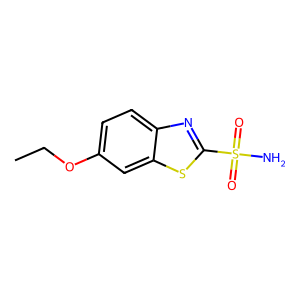

In [19]:
from rdkit import Chem
from rdkit.Chem import Draw
import networkx as nx
import matplotlib.pyplot as plt

smiles_sample = tox_data['smiles'][0].strip()
mol = Chem.MolFromSmiles(smiles_sample)
Draw.MolToImage(mol)


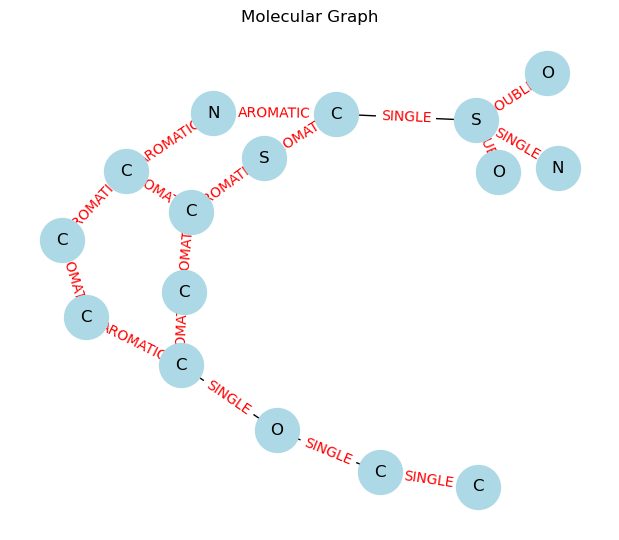

In [20]:
def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    G = nx.Graph()
    
    # 添加原子节点
    for atom in mol.GetAtoms():
        idx = atom.GetIdx()
        G.add_node(idx, label=atom.GetSymbol())
    
    # 添加键（边）
    for bond in mol.GetBonds():
        a1 = bond.GetBeginAtomIdx()
        a2 = bond.GetEndAtomIdx()
        bond_type = str(bond.GetBondType())
        G.add_edge(a1, a2, label=bond_type)
    
    return G, mol

def draw_graph(G):
    pos = nx.spring_layout(G)
    labels = nx.get_node_attributes(G, 'label')
    edge_labels = nx.get_edge_attributes(G, 'label')

    plt.figure(figsize=(6, 5))
    nx.draw(G, pos, with_labels=True, labels=labels, node_color='lightblue', node_size=1000, font_size=12)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    plt.title("Molecular Graph")
    plt.axis('off')
    plt.show()
    
    
G, mol = smiles_to_graph(smiles_sample)
draw_graph(G)